# Introduction to rio-tiler

The goal of this notebook is to give a quick introduction of the main rio-tiler features.

# Requirements

To be able to run this notebook you'll need the following requirements:
- rio-tiler~= 4.0
- matplotlib

In [7]:
# !pip install rio-tiler matplotlib

In [20]:
import morecantile
from rio_tiler.io import Reader
from rio_tiler.profiles import img_profiles
from rio_tiler.models import ImageData

from matplotlib.pyplot import plot, imshow, subplots

In [2]:
# For this DEMO we will use this file
src_path = "https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2573-1085/swissalti3d_2019_2573-1085_0.5_2056_5728.tif"

## rio_tiler.io.COGReader

In `rio-tiler` 2.0 we introduced COGReader (renamed Reader in 4.0), which is a python class providing usefull methods to read and inspect any GDAL/rasterio raster dataset.

Docs: [https://cogeotiff.github.io/rio-tiler/readers/#cogreader](https://cogeotiff.github.io/rio-tiler/readers/#cogreader) 

In [3]:
?Reader

Init signature:
Reader(
    input: str,
    dataset: Union[rasterio.io.DatasetReader, rasterio.io.DatasetWriter, rasterio.io.MemoryFile, rasterio.vrt.WarpedVRT] = None,
    tms: morecantile.models.TileMatrixSet = <TileMatrixSet title='Google Maps Compatible for the World' identifier='WebMercatorQuad'>,
    geographic_crs: rasterio.crs.CRS = CRS.from_epsg(4326),
    colormap: Dict = None,
    options: rio_tiler.reader.Options = NOTHING,
) -> None
Docstring:     
Rasterio Reader.

Attributes:
    input (str): dataset path.
    dataset (rasterio.io.DatasetReader or rasterio.io.DatasetWriter or rasterio.vrt.WarpedVRT, optional): Rasterio dataset.
    tms (morecantile.TileMatrixSet, optional): TileMatrixSet grid definition. Defaults to `WebMercatorQuad`.
    geographic_crs (rasterio.crs.CRS, optional): CRS to use as geographic coordinate system. Defaults to WGS84.
    colormap (dict, optional): Overwrite internal colormap.
    options (dict, optional): Options to forward to low-level reader

### Info

Read GDAL/Rasterio dataset metadata

In [30]:
# As for Rasterio, using context manager is a good way to 
# make sure the dataset are closed when we exit.
with Reader(src_path) as src:
    print("rasterio dataset:")
    print(src.dataset)
    print()
    print("metadata from rasterio:")
    print(src.dataset.meta)
    print()
    # Using rio-tiler Info() method
    info = src.info()
    print("rio-tiler dataset info:")
    print(src.info().json(exclude_none=True))

print(src.dataset.closed)

rasterio dataset:
<open DatasetReader name='https://njogis-imagery.s3.amazonaws.com/2020/cog/I7D16.tif' mode='r'>

metadata from rasterio:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 5000, 'height': 5000, 'count': 4, 'crs': CRS.from_epsg(6527), 'transform': Affine(1.0, 0.0, 544999.99999999,
       0.0, -1.0, 650000.0)}

rio-tiler dataset info:
{"bounds": [-74.3095632062702, 40.603994417539994, -74.29151245384847, 40.61775082944064], "minzoom": 14, "maxzoom": 19, "band_metadata": [["b1", {}], ["b2", {}], ["b3", {}], ["b4", {}]], "band_descriptions": [["b1", ""], ["b2", ""], ["b3", ""], ["b4", ""]], "dtype": "uint16", "nodata_type": "None", "colorinterp": ["red", "green", "blue", "undefined"], "overviews": [2, 4, 8, 16], "height": 5000, "width": 5000, "count": 4, "driver": "GTiff"}
True


### Statistics

Return basic data statistics

In [29]:
with Reader(src_path) as src:
    meta = src.statistics(max_size=256)

    assert isinstance(meta, dict)
    print(list(meta))
    print(meta["b1"].dict())

['b1', 'b2', 'b3', 'b4']
{'min': 2074.0, 'max': 63290.0, 'mean': 18474.233474731445, 'count': 65536.0, 'sum': 1210727365.0, 'std': 6623.984653299175, 'median': 17826.0, 'majority': 19834.0, 'minority': 2074.0, 'unique': 23890.0, 'histogram': [[3289.0, 13676.0, 26643.0, 14944.0, 4876.0, 1585.0, 411.0, 67.0, 35.0, 10.0], [2074.0, 8195.6, 14317.2, 20438.800000000003, 26560.4, 32682.0, 38803.600000000006, 44925.200000000004, 51046.8, 57168.4, 63290.0]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 65536.0, 'percentile_2': 6801.7, 'percentile_98': 34989.89999999999}


#### Plot Histogram values

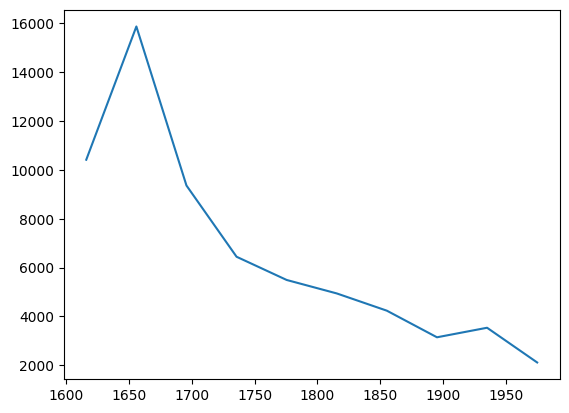

In [11]:
# Band 1
plot(meta["b1"].histogram[1][0:-1], meta["b1"].histogram[0])

### Preview

Read a low resolution version of the data (useful when working with COG, because this method will only fetch the overview layer it needs)

In [28]:
with Reader(src_path) as src:
    # By default `preview()` will return an array with its longest dimension lower or equal to 1024px
    data = src.preview()
    print(data.data.shape)
    assert isinstance(data, ImageData)

(4, 1024, 1024)


#### The ImageData class

To ease data manipulation, `rio-tiler` version 2.0 uses a new `ImageData` class that holds the arrays returned by rio-tiler/rasterio low level functions.

Docs: https://cogeotiff.github.io/rio-tiler/models/#imagedata

In [13]:
print(f"width: {data.width}")
print(f"height: {data.height}")
print(f"bands: {data.count}")
print(f"crs: {data.crs}")
print(f"bounds: {data.bounds}")
print(f"metadata: {data.metadata}")
print(f"assets: {data.assets}")
print(f"dataset stats: {data.dataset_statistics}")  # If stored in the original dataset

print(type(data.data))
print(type(data.mask))

width: 1024
height: 1024
bands: 1
crs: EPSG:2056
bounds: BoundingBox(left=2573000.0, bottom=1085000.0, right=2574000.0, top=1086000.0)
metadata: {}
assets: ['https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2573-1085/swissalti3d_2019_2573-1085_0.5_2056_5728.tif']
dataset stats: [(1615.8128662109, 2015.0944824219)]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### Display the data

<class 'rio_tiler.models.ImageData'>
(1, 1024, 1024)
<class 'numpy.ndarray'>
(1024, 1024, 1)


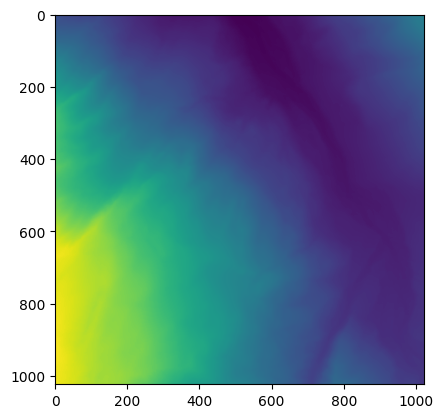

In [14]:
# Rasterio doesn't use the same axis order than visualization libraries (e.g matplotlib, PIL)
# in order to display the data we need to change the order (using rasterio.plot.array_to_image).
# the ImageData class wraps the rasterio function in the `data_as_image()` method.
print(type(data))
print(data.data.shape)

image = data.data_as_image()
# data_as_image() returns a numpy.ndarray
print(type(image))
print(image.shape)

imshow(image)

## Multi Spectral Data

For this demo we will use some High resolution RGB-Nir data hosted on [AWS](https://registry.opendata.aws/nj-imagery/).



In [15]:
src_path = "https://njogis-imagery.s3.amazonaws.com/2020/cog/I7D16.tif"

In [27]:
with Reader(src_path) as src:
    info = src.info()
    print("rio-tiler dataset info:")
    print(info.json(exclude_none=True))

rio-tiler dataset info:
{"bounds": [-74.3095632062702, 40.603994417539994, -74.29151245384847, 40.61775082944064], "minzoom": 14, "maxzoom": 19, "band_metadata": [["b1", {}], ["b2", {}], ["b3", {}], ["b4", {}]], "band_descriptions": [["b1", ""], ["b2", ""], ["b3", ""], ["b4", ""]], "dtype": "uint16", "nodata_type": "None", "colorinterp": ["red", "green", "blue", "undefined"], "overviews": [2, 4, 8, 16], "height": 5000, "width": 5000, "count": 4, "driver": "GTiff"}


['b1', 'b2', 'b3', 'b4']


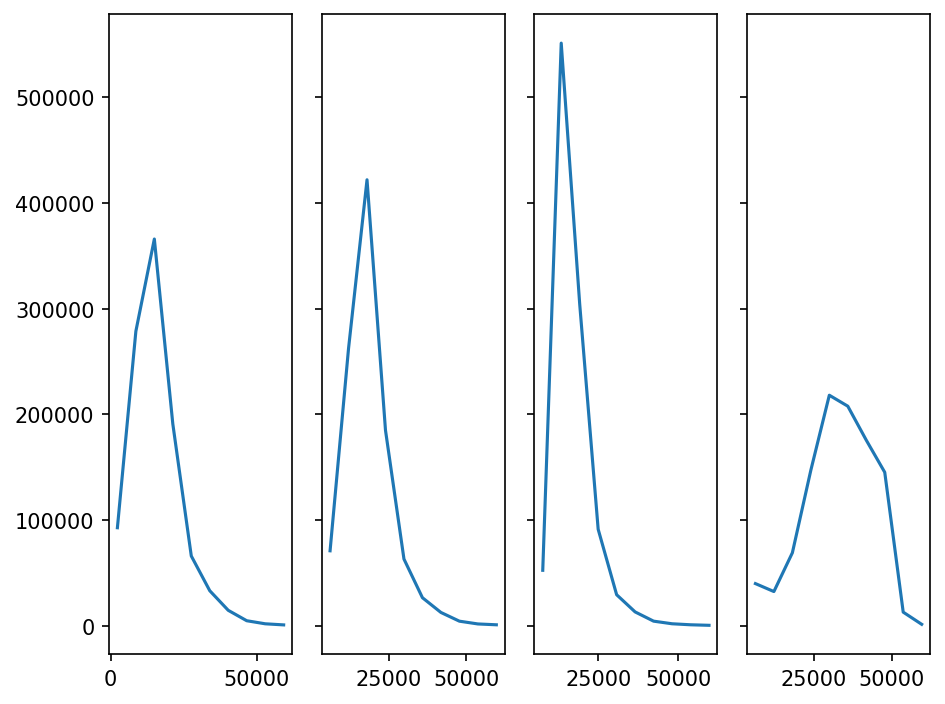

In [21]:
with Reader(src_path) as src:
    meta = src.statistics()

print(list(meta))
    
fig, axs = subplots(1, 4, sharey=True, tight_layout=True, dpi=150)
# Red (index 1)
axs[0].plot(meta["b1"].histogram[1][0:-1], meta["b1"].histogram[0])

# Green (index 2)
axs[1].plot(meta["b2"].histogram[1][0:-1], meta["b2"].histogram[0])

# Blue (index 3)
axs[2].plot(meta["b3"].histogram[1][0:-1], meta["b3"].histogram[0])

# Nir (index 3)
axs[3].plot(meta["b4"].histogram[1][0:-1], meta["b4"].histogram[0])

#### Using Expression

`rio-tiler` reader methods accept `indexes` option to select the bands you want to read, but also `expression` to perform band math.

(1, 1024, 1024)
uint16


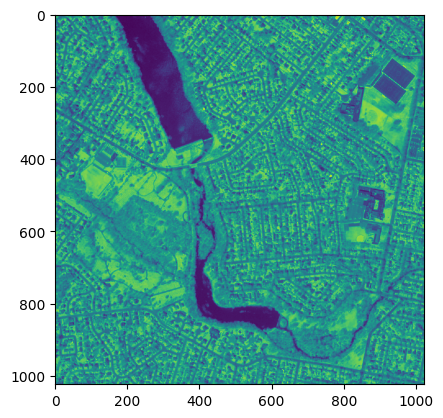

In [22]:
with Reader(src_path) as src:
    # Return only the third band
    nir_band = src.preview(indexes=4)
    print(nir_band.data.shape)
    print(nir_band.data.dtype)

imshow(nir_band.data_as_image())

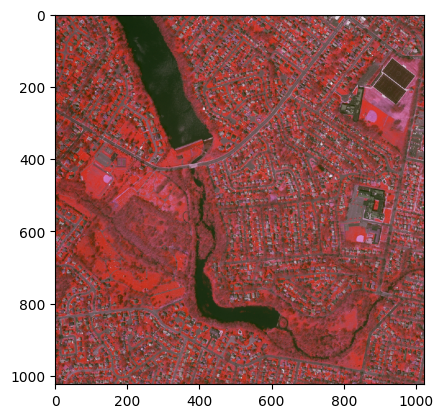

In [23]:
with Reader(src_path) as src:
    # Return only the third band
    nrg = src.preview(indexes=(4,3,1))
    
    # Data is in Uint16 so we need to rescale
    nrg.rescale(((nrg.data.min(), nrg.data.max()),))

imshow(nrg.data_as_image())

(1, 1024, 1024)
float64
NDVI range:  -0.2865547317109613 0.844091888413218


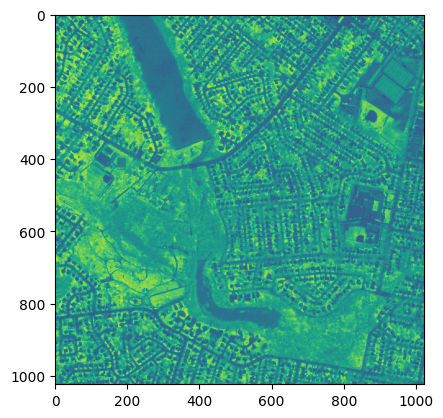

In [24]:
with Reader(src_path) as src:
    # Apply NDVI band math
    # (NIR - RED) / (NIR + RED)
    ndvi = src.preview(expression="(b4-b1)/(b4+b1)")
    print(ndvi.data.shape)
    print(ndvi.data.dtype)
    print("NDVI range: ", ndvi.data.min(), ndvi.data.max())

ndvi.rescale(in_range=((-1,1),))
imshow(ndvi.data_as_image())

### Tile

Read data for a specific slippy map tile coordinates

In [31]:
with Reader(src_path) as src:
    print(f"Bounds in dataset CRS: {src.bounds}")
    print(f"Bounds WGS84: {src.geographic_bounds}")
    print(f"MinZoom (WebMercator): {src.minzoom}")
    print(f"MaxZoom (WebMercator): {src.maxzoom}")

Bounds in dataset CRS: (544999.99999999, 645000.0, 549999.99999999, 650000.0)
Bounds WGS84: (-74.3095632062702, 40.603994417539994, -74.29151245384847, 40.61775082944064)
MinZoom (WebMercator): 14
MaxZoom (WebMercator): 19


In [32]:
# rio-tiler defaults to the WebMercator Grids. The grid definition is provided by the morecantile module
# Docs: https://github.com/developmentseed/morecantile
tms = morecantile.tms.get("WebMercatorQuad")
print(repr(tms))

# Get the list of tiles for the COG minzoom 
with Reader(src_path) as cog:
    tile_cover = list(tms.tiles(*cog.geographic_bounds, zooms=cog.minzoom))

print(f"Nb of Z{cog.minzoom} Mercator tiles: {len(tile_cover)}")
print(tile_cover)

<TileMatrixSet title='Google Maps Compatible for the World' identifier='WebMercatorQuad'>
Nb of Z14 Mercator tiles: 2
[Tile(x=4810, y=6165, z=14), Tile(x=4810, y=6166, z=14)]


In [33]:
with Reader(src_path) as src:
    img_1 = src.tile(*tile_cover[0])
    img_1.rescale(((0, 40000),))
    print(img_1.data.shape)

    img_2 = src.tile(*tile_cover[1])
    img_2.rescale(((0, 40000),))

    print(img_2.data.shape)

(4, 256, 256)
(4, 256, 256)


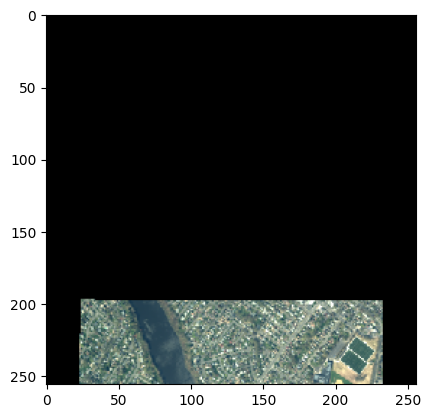

In [45]:
# Show the first 3 bands (RGB)
imshow(img_1.data_as_image()[:,:,0:3])

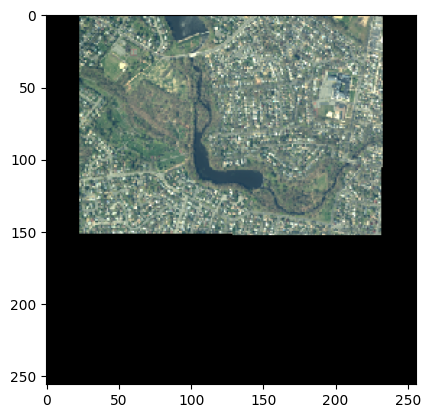

In [35]:
imshow(img_2.data_as_image()[:,:,0:3])

(1, 256, 256)


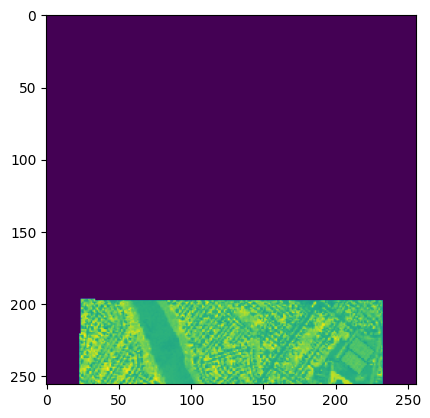

In [36]:
with Reader(src_path) as src:
    ndvi = src.tile(*tile_cover[0], expression="(b4-b1)/(b4+b1)")
    print(ndvi.data.shape)

ndvi.rescale(in_range=((-1,1),))
imshow(ndvi.data[0])

### Part 

Read data for a given bounding box

In [44]:
with Reader(src_path) as src:
    # By default `part()` will read the highest resolution. We can limit this by using the `max_size` option.
    img = src.part((-74.30680274963379, 40.60748547709819, -74.29478645324707, 40.61567903099978), max_size=1024)
    print("data shape: ", img.data.shape)
    print("bounds: ", img.bounds)
    print("CRS: ", img.crs)

data shape:  (4, 699, 1024)
bounds:  BoundingBox(left=-74.30680274963379, bottom=40.60748547709819, right=-74.29478645324707, top=40.61567903099978)
CRS:  EPSG:4326


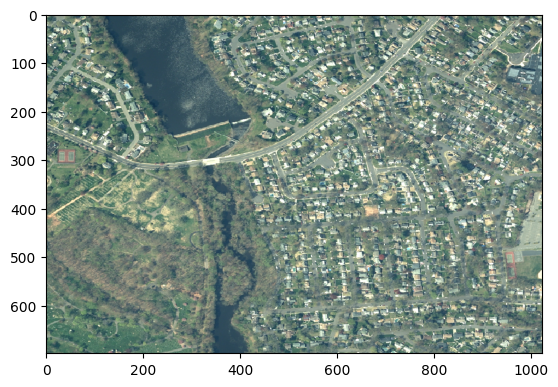

In [38]:
img.rescale(((0, 40000),))

imshow(img.data_as_image()[:,:,0:3])

### Point

Read the pixel value for a specific lon/lat coordinate

In [43]:
with Reader(src_path) as src:
    pt = src.point(-74.30680274963379, 40.60748547709819)

    print("RGB-Nir values:")
    print([(b, pt.data[ii]) for ii, b in enumerate(pt.band_names)])

    print("NDVI values:")
    ndvi = pt.apply_expression("(b4-b1)/(b4+b1)")
    print([(b, ndvi.data[ii]) for ii, b in enumerate(ndvi.band_names)])

RGB-Nir values
[('b1', 11002), ('b2', 15954), ('b3', 14478), ('b4', 32050)]
NDVI values
[('(b4-b1)/(b4+b1)', 0.48889714763541764)]


### Feature/GeoJSON

Read value for a geojson feature defined area

In [46]:
feat = {
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          -74.30384159088135,
          40.614245638811646
        ],
        [
          -74.30680274963379,
          40.61121586776988
        ],
        [
          -74.30590152740477,
          40.608967884350946
        ],
        [
          -74.30272579193115,
          40.60748547709819
        ],
        [
          -74.29875612258911,
          40.60786015456402
        ],
        [
          -74.2960524559021,
          40.61012446497514
        ],
        [
          -74.29478645324707,
          40.61390357476733
        ],
        [
          -74.29882049560547,
          40.61515780103489
        ],
        [
          -74.30294036865233,
          40.61567903099978
        ],
        [
          -74.3035626411438,
          40.61502749290829
        ],
        [
          -74.30384159088135,
          40.614245638811646
        ]
      ]
    ]
  }
}

In [48]:
with Reader(src_path) as src:
    # we use the feature to define the bounds and the mask
    # but we use `dst_crs` options to keep the projection from the input dataset
    # By default `feature()` will read the highest resolution. We can limit this by using the `max_size` option.
    img = src.feature(feat, dst_crs=src.crs, max_size=1024)
    print("data shape: ", img.data.shape)
    print("bounds: ", img.bounds)
    print("CRS: ", img.crs)

data shape:  (4, 917, 1024)
bounds:  BoundingBox(left=545757.1269694079, bottom=646262.0947405763, right=549099.8472835454, top=649254.4633358676)
CRS:  EPSG:6527


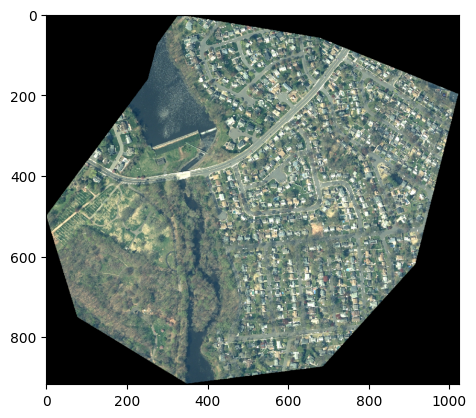

In [49]:
img.rescale(((0, 40000),))
imshow(img.data_as_image()[:,:,0:3])